
# Gold Price Forecast & 30 days Predictions

## Analysis
Data spans from the inception of this share from 01/01/2016 to the date of download, 21/12/2021

## Techniques Used
- EDA and visualize data
- Check If Time Series Data is Stationary using Dicky-Fuller Test
- Make the Time Series Data Stationary
- Use ACF and PACF to Choose the Model Order 
- Use AIC and BIC Results to Pick the Optimal Model Order
- Use SARIMA Model
- Use LSTM Model
- Use LSTM to forecast out 30 days for gold prices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas import DataFrame
import itertools
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from math import sqrt
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

# Analysis imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore') #this would remove any deprecated warning

In [2]:
 sns.set_theme(style='white')

In [3]:
df=pd.read_excel(r'/content/Gold_data.xlsx')
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2182 non-null   datetime64[ns]
 1   price   2182 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 34.2 KB


In [5]:
df.describe()

,price
count,2182.000000
mean,3284.450046
std,719.564434
min,2252.600000
25%,2697.020000
50%,2879.800000
75%,4147.325000
max,4966.300000


In [6]:
print('dates available are from : ',df.date.iloc[0],'to',df.date.iloc[-1] )

dates available are from :  2016-01-01 00:00:00 to 2021-12-21 00:00:00


In [7]:
df['Month'] = pd.to_datetime(df.date).dt.strftime('%b')
df['Year'] = pd.to_datetime(df.date).dt.strftime('%Y')
df['dayno']=pd.to_datetime(df.date).dt.strftime('%d')

In [8]:
df.sample(5)

,date,price,Month,Year,dayno
1873,2021-02-16,4200.3,Feb,2021,16
1857,2021-01-31,4326.4,Jan,2021,31
1982,2021-06-05,4287.7,Jun,2021,05
2094,2021-09-25,4147.6,Sep,2021,25
967,2018-08-25,2699.6,Aug,2018,25


In [9]:
df[["date"]] = df[["date"]].apply(pd.to_datetime)
df[['Month']]=df[['Month']].astype('str')
df[['Year']]=df[['Year']].astype(int)
df[['dayno']]=df[['dayno']].astype(int)

In [10]:
df.dtypes

date     datetime64[ns]
price           float64
Month            object
Year              int64
dayno             int64
dtype: object

In [11]:
df['day']=df['date'].dt.day_name()

In [12]:
df['change']=df['price'].pct_change() 
df['Difference']=df['price'].diff() 

In [13]:

df.dtypes

date          datetime64[ns]
price                float64
Month                 object
Year                   int64
dayno                  int64
day                   object
change               float64
Difference           float64
dtype: object

In [14]:
df['day']=df['date'].dt.day_name()

In [15]:
df['change']=df['price'].pct_change() 
df['Difference']=df['price'].diff() 

In [16]:
df["Quarter"] = df.date.dt.quarter

In [17]:
df.head()

,date,price,Month,Year,dayno,day,change,Difference,Quarter
0,2016-01-01,2252.60,Jan,2016,1,Friday,NaN,NaN,1
1,2016-01-02,2454.50,Jan,2016,2,Saturday,0.089630,201.90,1
2,2016-01-03,2708.10,Jan,2016,3,Sunday,0.103320,253.60,1
3,2016-01-04,2577.80,Jan,2016,4,Monday,-0.048115,-130.30,1
4,2016-01-05,2597.75,Jan,2016,5,Tuesday,0.007739,19.95,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2182 entries, 0 to 2181
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2182 non-null   datetime64[ns]
 1   price       2182 non-null   float64       
 2   Month       2182 non-null   object        
 3   Year        2182 non-null   int64         
 4   dayno       2182 non-null   int64         
 5   day         2182 non-null   object        
 6   change      2181 non-null   float64       
 7   Difference  2181 non-null   float64       
 8   Quarter     2182 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 153.5+ KB


In [19]:
df=df.iloc[1:]

In [20]:
df

,date,price,Month,Year,dayno,day,change,Difference,Quarter
1,2016-01-02,2454.50,Jan,2016,2,Saturday,0.089630,201.90,1
2,2016-01-03,2708.10,Jan,2016,3,Sunday,0.103320,253.60,1
3,2016-01-04,2577.80,Jan,2016,4,Monday,-0.048115,-130.30,1
4,2016-01-05,2597.75,Jan,2016,5,Tuesday,0.007739,19.95,1
5,2016-01-06,2617.70,Jan,2016,6,Wednesday,0.007680,19.95,1
...,...,...,...,...,...,...,...,...,...
2177,2021-12-17,4394.40,Dec,2021,17,Friday,-0.001227,-5.40,4
2178,2021-12-18,4389.50,Dec,2021,18,Saturday,-0.001115,-4.90,4
2179,2021-12-19,4389.50,Dec,2021,19,Sunday,0.000000,0.00,4
2180,2021-12-20,4354.10,Dec,2021,20,Monday,-0.008065,-35.40,4


In [21]:
df[['price','change','Difference']].describe()

,price,change,Difference
count,2181.000000,2181.000000,2181.000000
mean,3284.923155,0.000805,0.960064
std,719.389923,0.031395,113.947909
min,2299.800000,-0.249826,-1187.100000
25%,2697.200000,-0.005752,-18.300000
50%,2879.800000,0.000000,0.000000
75%,4147.600000,0.006973,22.800000
max,4966.300000,0.170527,687.800000


In [22]:
df[df['price']==4966.300000]

,date,price,Month,Year,dayno,day,change,Difference,Quarter
1620,2020-06-08,4966.3,Jun,2020,8,Monday,0.160757,687.8,2


In [23]:
df[df['price']==2299.800000]

,date,price,Month,Year,dayno,day,change,Difference,Quarter
91,2016-04-01,2299.8,Apr,2016,1,Friday,-0.125352,-329.6,2


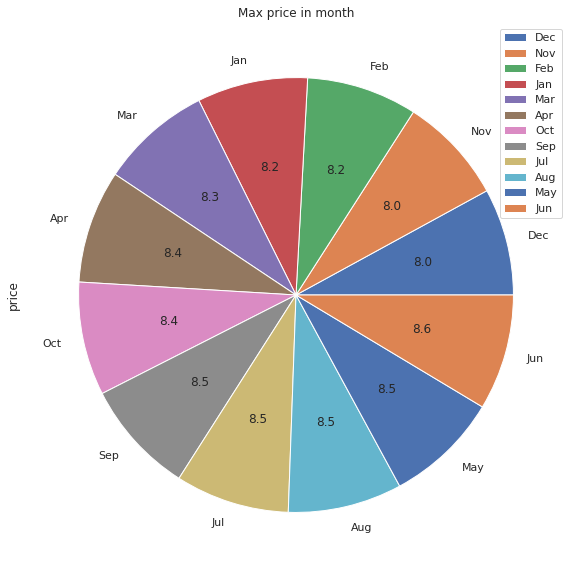

In [24]:
_, ax = plt.subplots(figsize=(10,10))
dfm=df.groupby(['Month']).max().sort_values(by='price').plot.pie(y='price',autopct='%1.1f',ax=ax,title='Max price in month')

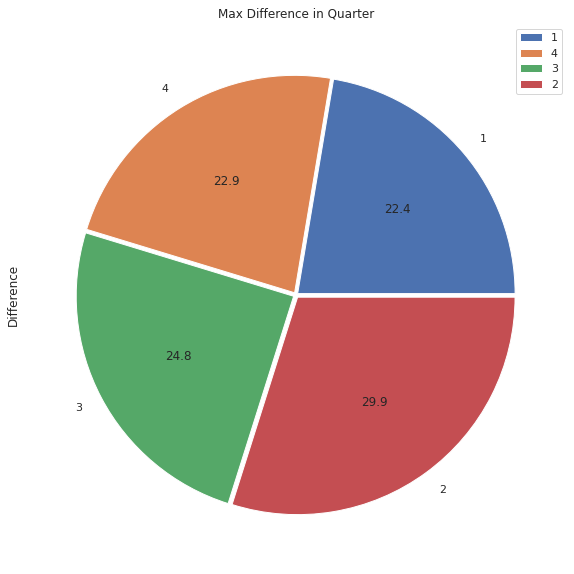

In [25]:
_, ax = plt.subplots(figsize=(10,10))
explode=[0.01,0.012,0.0123,0.0125]
dfq=df.groupby(['Quarter']).max().sort_values(by='price').plot.pie(y='Difference',autopct='%1.1f',explode=explode,ax=ax,title='Max Difference in Quarter')

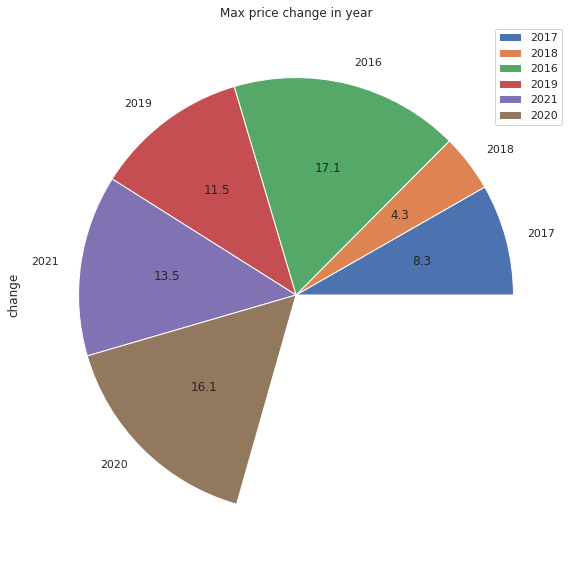

In [26]:
_, ax = plt.subplots(figsize=(10,10))
dfy=df.groupby(['Year']).max().sort_values(by='price').plot.pie(y='change',autopct='%1.1f',ax=ax,title='Max price change in year')

In [27]:
dfdate=df[['date','price']]

In [28]:
dfdate.set_index('date', inplace=True)

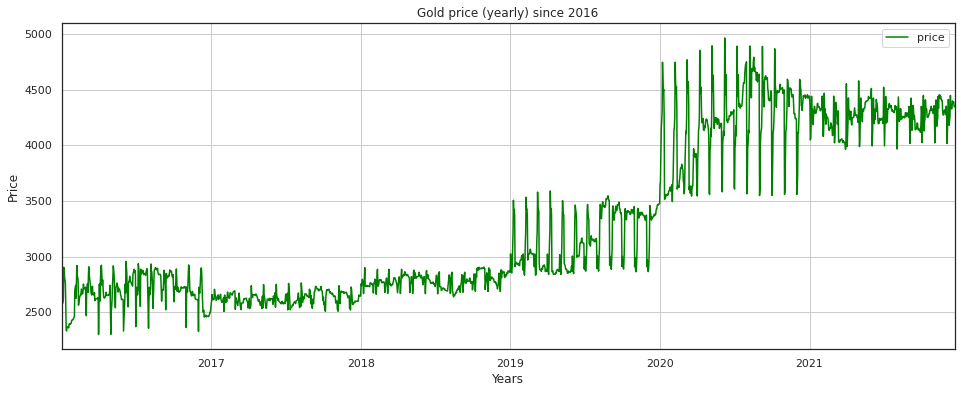

In [29]:
dfdate.plot(figsize=(16,6),color='green')
plt.title("Gold price (yearly) since 2016")
plt.xlabel("Years")
plt.ylabel("Price")
plt.grid();

In [30]:
dfqd=df[['Quarter','Difference']]

In [31]:
dfqd.set_index('Quarter',inplace=True)

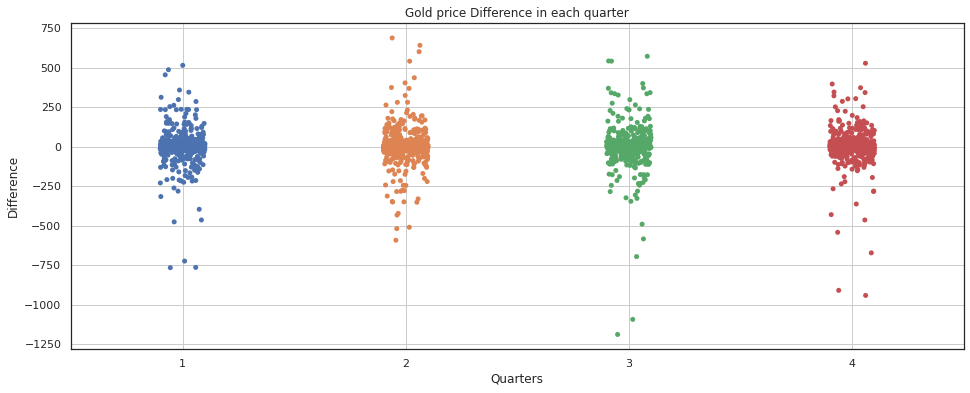

In [32]:
_, ax = plt.subplots(figsize=(16,6))
sns.stripplot(x = dfqd.index,y = dfqd.Difference,ax=ax)
plt.title("Gold price Difference in each quarter")
plt.xlabel("Quarters")
plt.ylabel("Difference")
plt.grid();

In [33]:
df2020=df[['Month','price','Year','dayno']]

In [34]:
df2020=df2020[df2020['Year']==2020]
df2020=df2020.drop('Year',axis=1)

In [35]:
df2020.set_index('Month',inplace=True)

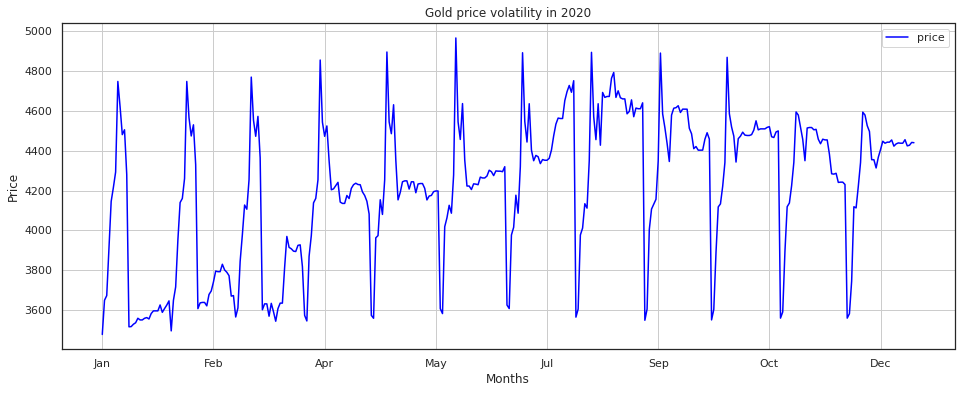

In [36]:
df2020[['price']].plot(figsize=(16,6),color='blue')
plt.title("Gold price volatility in 2020")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [37]:
df2020_jan=df2020[df2020.index=='Jan']

In [38]:
df2020_jan.set_index('dayno',inplace=True)

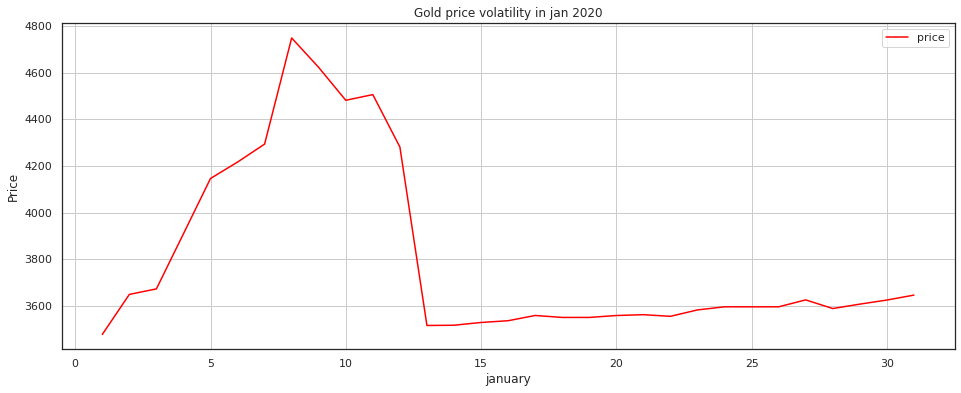

In [39]:

df2020_jan[['price']].plot(figsize=(16,6),color='red')
plt.title("Gold price volatility in jan 2020")
plt.xlabel("january")
plt.ylabel("Price")
plt.grid();

In [40]:
dfmonths=df.groupby('Month')[['price','Difference']].std()
dfmonths=dfmonths.reset_index()

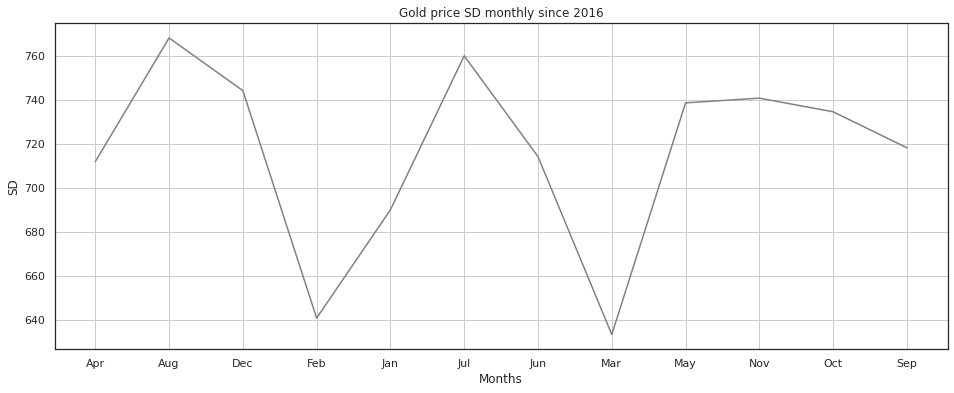

In [41]:
_, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x ='Month',y='price',data=dfmonths,ax=ax,color='grey')
plt.title("Gold price SD monthly since 2016")
plt.xlabel("Months")
plt.ylabel("SD")
plt.grid();

In [42]:
dfmon=df

In [43]:
dfmon

,date,price,Month,Year,dayno,day,change,Difference,Quarter
1,2016-01-02,2454.50,Jan,2016,2,Saturday,0.089630,201.90,1
2,2016-01-03,2708.10,Jan,2016,3,Sunday,0.103320,253.60,1
3,2016-01-04,2577.80,Jan,2016,4,Monday,-0.048115,-130.30,1
4,2016-01-05,2597.75,Jan,2016,5,Tuesday,0.007739,19.95,1
5,2016-01-06,2617.70,Jan,2016,6,Wednesday,0.007680,19.95,1
...,...,...,...,...,...,...,...,...,...
2177,2021-12-17,4394.40,Dec,2021,17,Friday,-0.001227,-5.40,4
2178,2021-12-18,4389.50,Dec,2021,18,Saturday,-0.001115,-4.90,4
2179,2021-12-19,4389.50,Dec,2021,19,Sunday,0.000000,0.00,4
2180,2021-12-20,4354.10,Dec,2021,20,Monday,-0.008065,-35.40,4


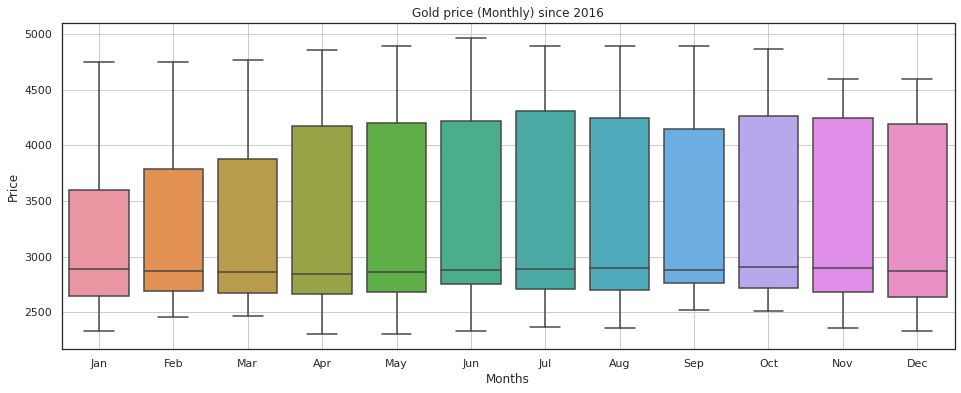

In [44]:
_, ax = plt.subplots(figsize=(16,6))
sns.boxplot(x ='Month',y ='price',data=dfmon,ax=ax)
plt.title("Gold price (Monthly) since 2016")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [45]:
dfq=df[['Quarter','price']]

In [46]:
dfq.set_index('Quarter',inplace=True)

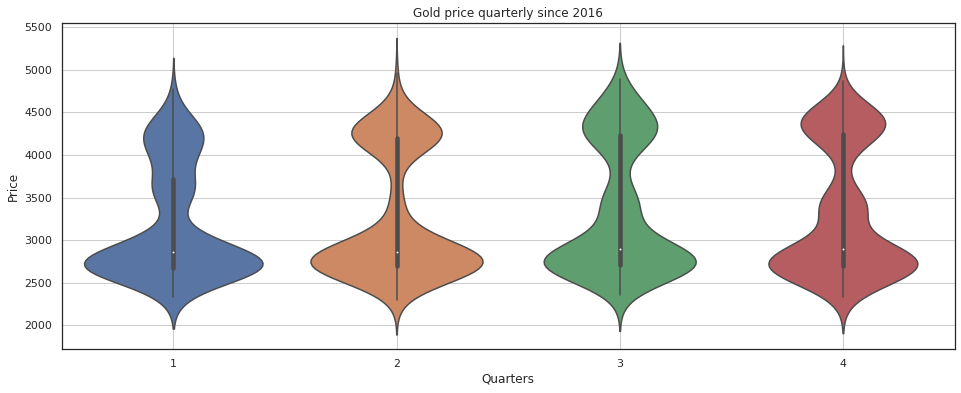

In [47]:
_, ax = plt.subplots(figsize=(16,6))
sns.violinplot(x = dfq.index,y = dfq.price,ax=ax)
plt.title("Gold price quarterly since 2016")
plt.xlabel("Quarters")
plt.ylabel("Price")
plt.grid();

In [48]:
dfd=df[['dayno','price']]

In [49]:
dfd.set_index('dayno',inplace=True)

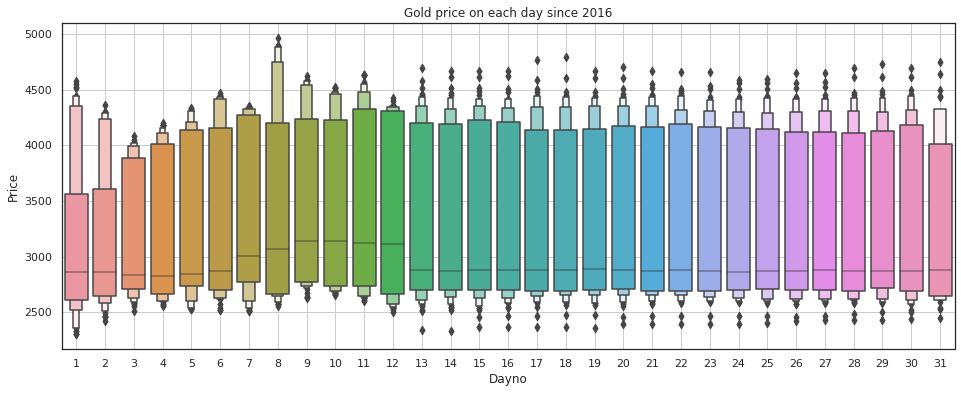

In [50]:
_, ax = plt.subplots(figsize=(16,6))
sns.boxenplot(x = dfd.index,y = dfd.price,ax=ax)
plt.title("Gold price on each day since 2016")
plt.xlabel("Dayno")
plt.ylabel("Price")
plt.grid();

In [51]:
dfs=df[['Difference','price','change']]

In [52]:
dfs=dfs.iloc[1:]

In [53]:
dfs

,Difference,price,change
2,253.60,2708.10,0.103320
3,-130.30,2577.80,-0.048115
4,19.95,2597.75,0.007739
5,19.95,2617.70,0.007680
6,286.10,2903.80,0.109294
...,...,...,...
2177,-5.40,4394.40,-0.001227
2178,-4.90,4389.50,-0.001115
2179,0.00,4389.50,0.000000
2180,-35.40,4354.10,-0.008065


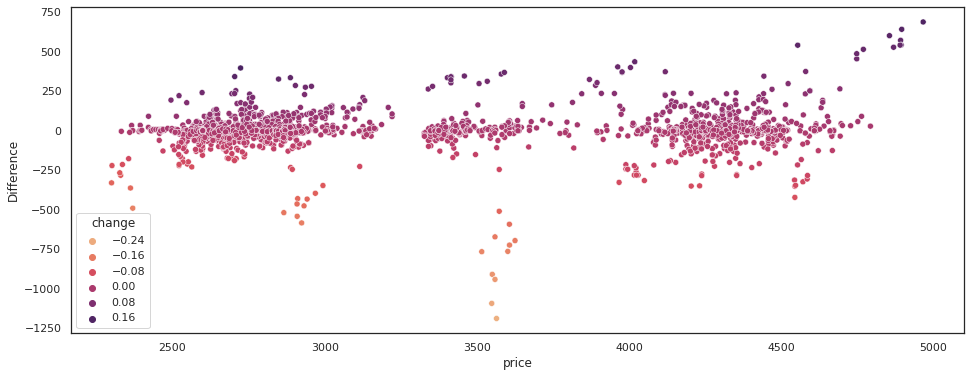

In [54]:
_, ax = plt.subplots(figsize=(16,6))
sns.scatterplot(x='price',y='Difference',hue='change',palette="flare",data=dfs,ax=ax)
plt.show()

In [55]:
df

,date,price,Month,Year,dayno,day,change,Difference,Quarter
1,2016-01-02,2454.50,Jan,2016,2,Saturday,0.089630,201.90,1
2,2016-01-03,2708.10,Jan,2016,3,Sunday,0.103320,253.60,1
3,2016-01-04,2577.80,Jan,2016,4,Monday,-0.048115,-130.30,1
4,2016-01-05,2597.75,Jan,2016,5,Tuesday,0.007739,19.95,1
5,2016-01-06,2617.70,Jan,2016,6,Wednesday,0.007680,19.95,1
...,...,...,...,...,...,...,...,...,...
2177,2021-12-17,4394.40,Dec,2021,17,Friday,-0.001227,-5.40,4
2178,2021-12-18,4389.50,Dec,2021,18,Saturday,-0.001115,-4.90,4
2179,2021-12-19,4389.50,Dec,2021,19,Sunday,0.000000,0.00,4
2180,2021-12-20,4354.10,Dec,2021,20,Monday,-0.008065,-35.40,4


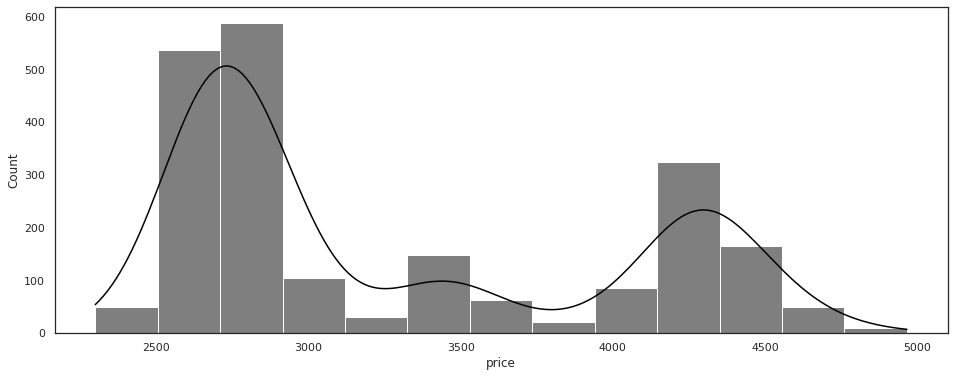

In [56]:
_, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=df,x='price',kde=True,color='black')
plt.show()

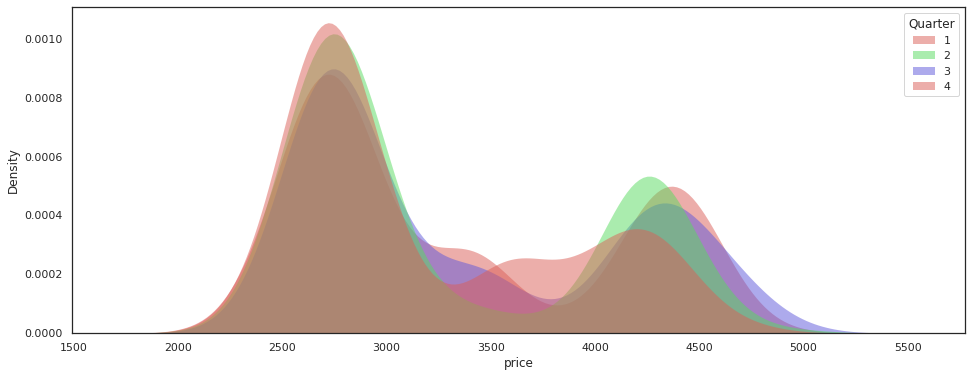

In [57]:
_, ax = plt.subplots(figsize=(16,6))
sns.kdeplot(ax=ax,data=df, x="price", hue="Quarter",fill=True, common_norm=False, palette="hls", alpha=.5, linewidth=0,)
plt.show()

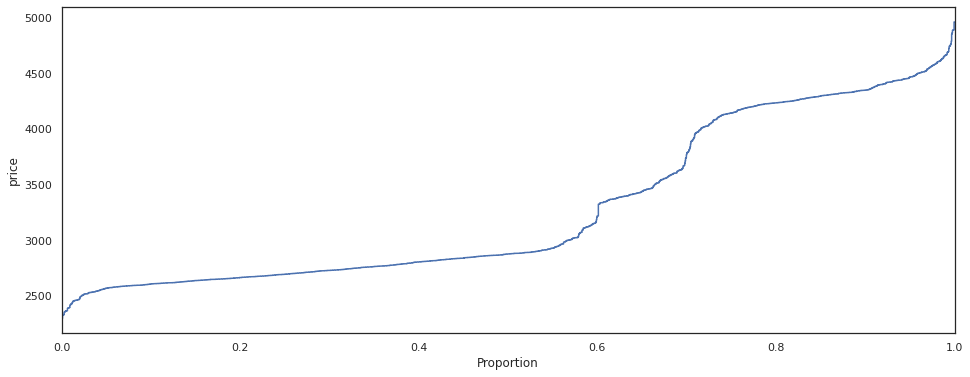

In [58]:
_, ax = plt.subplots(figsize=(16,6))
sns.ecdfplot(data=df, y="price",ax=ax)
plt.show()

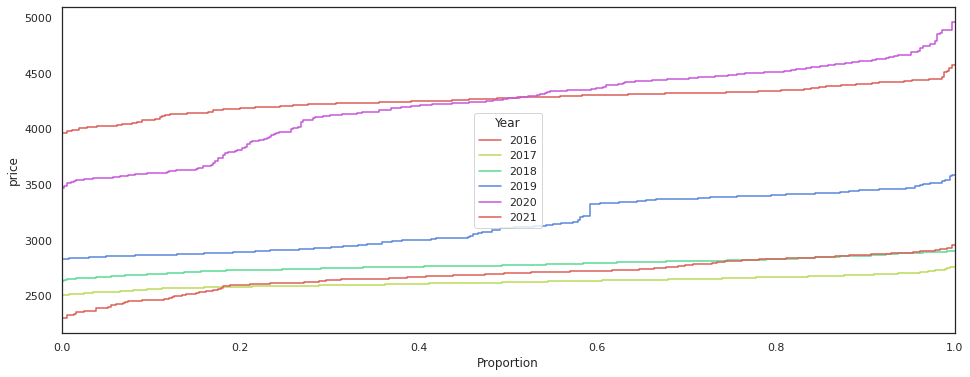

In [59]:
_, ax = plt.subplots(figsize=(16,6))
sns.ecdfplot(data=df, y="price",ax=ax,hue='Year',palette="hls")
plt.show()

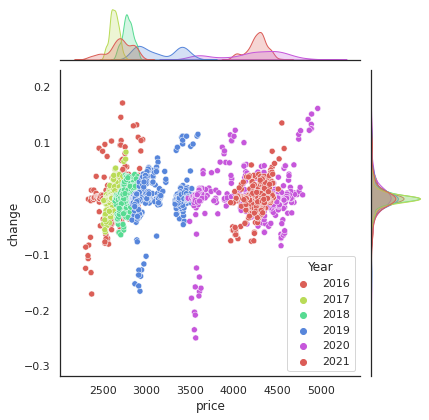

In [60]:
sns.jointplot(data=df, x="price", y="change", hue="Year",palette="hls")
plt.show()

# Check If Time Series Data is Stationary
Data needs to be stationary before modeling. Run Dicky-Fuller test on the Price

In [61]:
adfuller_result = adfuller(df['price'])
print('ADF Statistic: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])

ADF Statistic:  -0.30792912840960657
p-value:  0.9243737987633396


### Conclusion: The data is not stationary because the p-value is greater than 0.05

# Make the Time Series Data Stationary
Use the difference method, square root and take the difference twice method to see which is a best way to make the data stationary

In [62]:
# Diff Method
df['Difference'] = df['Difference'].dropna()
Difference_adfuller_result = adfuller(df['Difference'])
print('Difference Method ADF Statistic: ', Difference_adfuller_result[0])
print('Difference Method p-value: ', Difference_adfuller_result[1])

Difference Method ADF Statistic:  -21.66454212724638
Difference Method p-value:  0.0


In [63]:
df_sqrt = np.sqrt(df['price']).dropna()
sqrt_adfuller_result = adfuller(df_sqrt)
print('Square Root Method ADF Statistic: ', sqrt_adfuller_result[0])
print('Square Root Methodp-value: ', sqrt_adfuller_result[1])

Square Root Method ADF Statistic:  -0.3689970607815305
Square Root Methodp-value:  0.915147890317581


In [64]:
# Diff Twice Method
df_difftwice = df['Difference'].diff().dropna()
df_difftwice
difftwice_adfuller_result = adfuller(df_difftwice)
print('Difference Method ADF Statistic: ', difftwice_adfuller_result[0])
print('Difference Method p-value: ', difftwice_adfuller_result[1])

Difference Method ADF Statistic:  -16.299033159199187
Difference Method p-value:  3.280394331197137e-29


In [65]:
df

,date,price,Month,Year,dayno,day,change,Difference,Quarter
1,2016-01-02,2454.50,Jan,2016,2,Saturday,0.089630,201.90,1
2,2016-01-03,2708.10,Jan,2016,3,Sunday,0.103320,253.60,1
3,2016-01-04,2577.80,Jan,2016,4,Monday,-0.048115,-130.30,1
4,2016-01-05,2597.75,Jan,2016,5,Tuesday,0.007739,19.95,1
5,2016-01-06,2617.70,Jan,2016,6,Wednesday,0.007680,19.95,1
...,...,...,...,...,...,...,...,...,...
2177,2021-12-17,4394.40,Dec,2021,17,Friday,-0.001227,-5.40,4
2178,2021-12-18,4389.50,Dec,2021,18,Saturday,-0.001115,-4.90,4
2179,2021-12-19,4389.50,Dec,2021,19,Sunday,0.000000,0.00,4
2180,2021-12-20,4354.10,Dec,2021,20,Monday,-0.008065,-35.40,4


### Conclusion
The Square Root methods didn't produce a p-value less than 0.05. So we should eliminate it. Both Differencing once and twice methods produced a p-value less than 0.05 but Differencing Twice produced a much more negative ADF Statistic. That's what we want, the more negative the better.

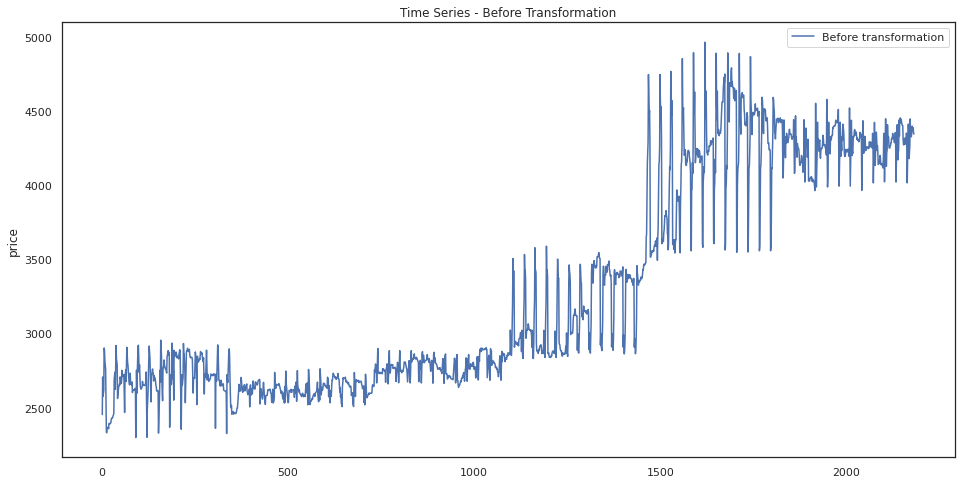

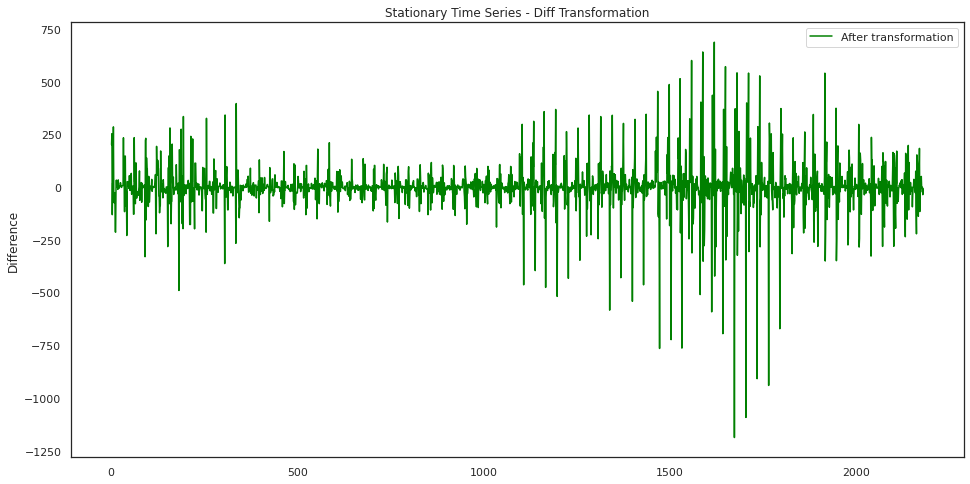

In [66]:
# Plot the time series before transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=df.index, y='price', data=df, linewidth=1.5, label='Before transformation').set_title('Time Series - Before Transformation')
plt.show()

# Plot the time series after transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=df.index, y='Difference', data=df, label='After transformation', color='green').set_title('Stationary Time Series - Diff Transformation')
plt.show()

# Which Model - AR, MA or ARMA. Use ACF and PACF to Choose the Model Order

**ACF** - Autocorrelation function to help select the right order.

**PACF** - Partial Autocorrelation is the correlation between the time series and the lag version of itself after we subtract the effect of correlation at smaller lags.So, it’s just the correlation associated with just that particular lag

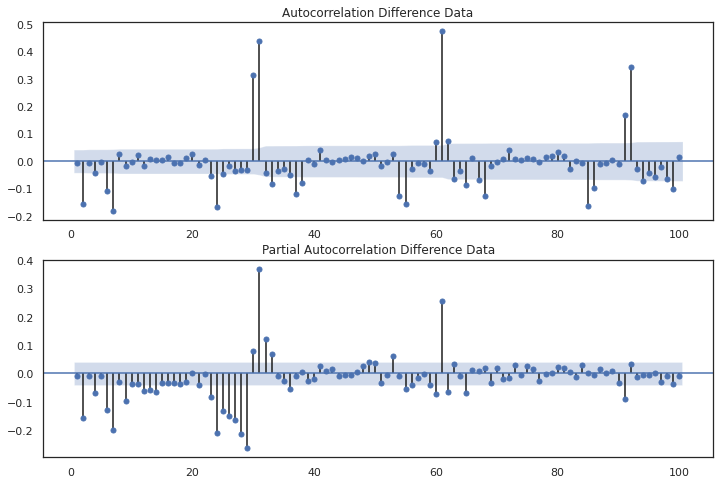

In [67]:
# Plot ACF and PACF with stationary data using data that was Difference

fig_difftwice, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of df_Difference
plot_acf(df['Difference'], lags=100, zero=False, ax=ax1, title='Autocorrelation Difference Data')

# Plot PACF of df_Difference
plot_pacf(df['Difference'], lags=100, zero=False, ax=ax2, title='Partial Autocorrelation Difference Data')

plt.show()

### Initial Observation
**ACF** - Cuts off after lag 30,60,90

**PACF** - tails off

**Initial conclusion:** It may be a MA(30),MA(60),MA(90),AR(30),AR(60),AR(90) model.

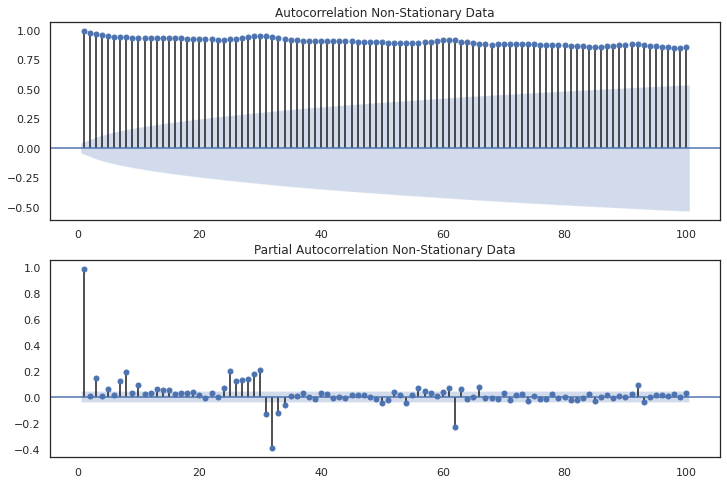

In [68]:
# Plot ACF and PACF with non-stationary data just to see how different they are compared to the stationary data

fig_data_gld, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of df_difference
plot_acf(df['price'], lags=100, zero=False, ax=ax1, title='Autocorrelation Non-Stationary Data')

# Plot PACF of df_difference
plot_pacf(df['price'], lags=100, zero=False, ax=ax2, title='Partial Autocorrelation Non-Stationary Data')

plt.show()


# Conclusion
The **ACF** cuts off after lag 1 and the **PACF** tails off. This may indicate that a Moving Average Model with an order of 1 MA(1) might be the best. However, there are limitations to the ACF and PACF method. We are making the judgement based on how the ACF and PACF graphs look. Sometimes it may not be as clear to make a conclusion. 

Next, let's use a different method to pick the optimal model order - the AIC and BIC.

In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [71]:
df=pd.read_excel('Gold_data.xlsx')

In [72]:
df.head()

,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [73]:
df.set_index('date',inplace=True)
df.head()

,price
date,
2016-01-01,2252.60
2016-01-02,2454.50
2016-01-03,2708.10
2016-01-04,2577.80
2016-01-05,2597.75


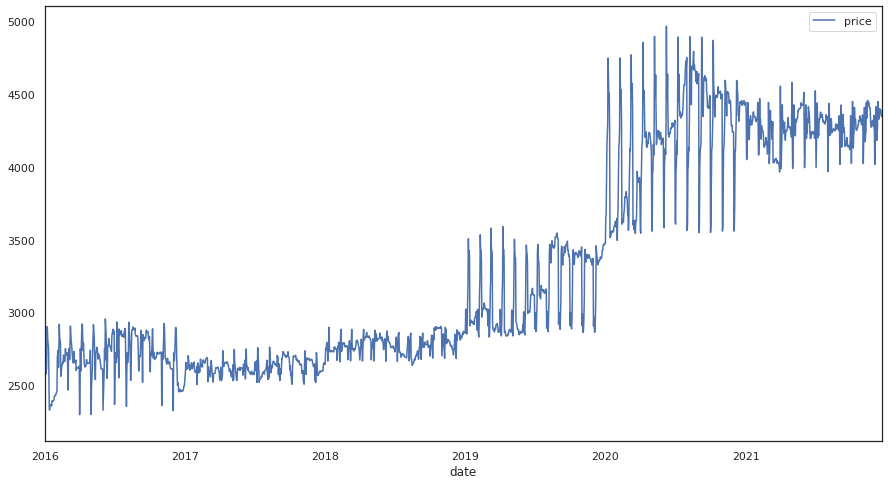

In [74]:
df.plot(figsize=(15,8))

In [75]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [76]:
test_result=adfuller(df['price'])

In [77]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print(" reject the null hypothesis.")
    else:
        print(" accept null hypothesis ")

In [78]:
adfuller_test(df['price'])

ADF Test Statistic : -0.3099036570504758
p-value : 0.9240899189079189
#Lags Used : 26
Number of Observations Used : 2155
 accept null hypothesis 


In [79]:
df['price First Difference'] = df['price'] - df['price'].shift(1)

In [80]:
df['Seasonal First Difference']=df['price']-df['price'].shift(30)

In [81]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -10.012615740241893
p-value : 1.7623278406162308e-17
#Lags Used : 7
Number of Observations Used : 2144
 reject the null hypothesis.


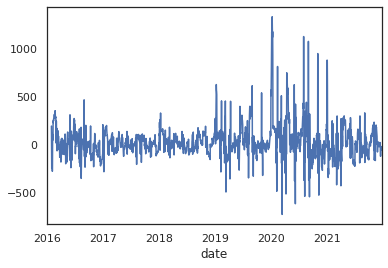

In [82]:
df['Seasonal First Difference'].plot()

In [83]:
## Again test dickey fuller test for first differencing
adfuller_test(df['price First Difference'].dropna())

ADF Test Statistic : -21.66454212724638
p-value : 0.0
#Lags Used : 26
Number of Observations Used : 2154
 reject the null hypothesis.


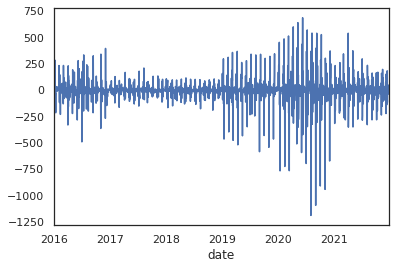

In [84]:
df['price First Difference'].plot()

In [85]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

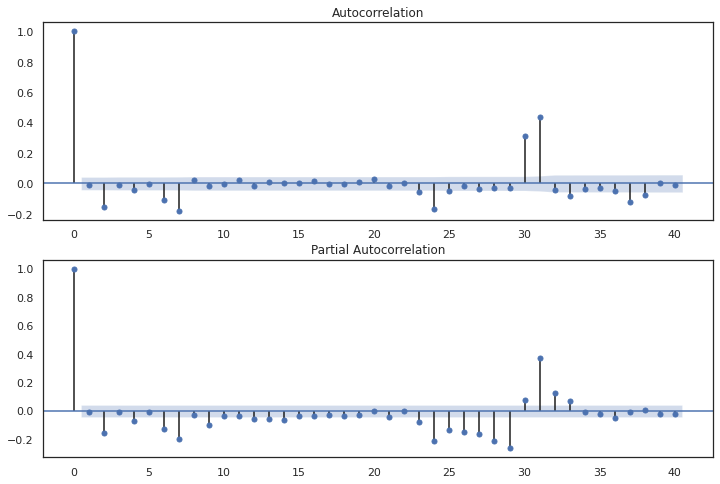

In [86]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['price First Difference'].iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['price First Difference'].iloc[1:],lags=40,ax=ax2)

In [87]:
from statsmodels.tsa.arima_model import ARIMA

In [88]:
model=ARIMA(df['price'],order=(1,1,1))
model_fit=model.fit()

In [89]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2181
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13326.934
Method:                       css-mle   S.D. of innovations            108.996
Date:                Wed, 14 Dec 2022   AIC                          26661.867
Time:                        17:17:03   BIC                          26684.617
Sample:                    01-02-2016   HQIC                         26670.184
                         - 12-21-2021                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8330      0.313      2.662      0.008       0.220       1.446
ar.L1.D.price     0.7811      0.015     51.012      0.000       0.751       0.811
ma.L1.D.price    -0.9711      0.005   -209.964      0.000      -0.980      -0.962
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2803           +0.0000j            1.2803            0.0000
MA.1            1.0298           +0.0000j            1.0298            0.0000
-----------------------------------------------------------------------------
"""

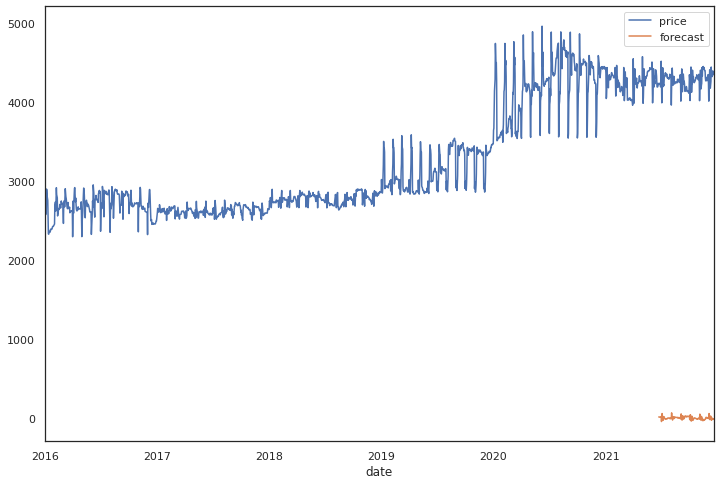

In [90]:
df['forecast']=model_fit.predict(start=2000,end=2182)
df[['price','forecast']].plot(figsize=(12,8))

In [91]:
model_fit.predict(start=2000,end=2182)

2021-06-23    17.411113
2021-06-24    17.165621
2021-06-25    18.086103
2021-06-26    15.256367
2021-06-27    14.351309
                ...    
2021-12-18   -11.034112
2021-12-19    -9.601566
2021-12-20    -9.141370
2021-12-21    -1.969246
2021-12-22    -0.286072
Freq: D, Length: 183, dtype: float64

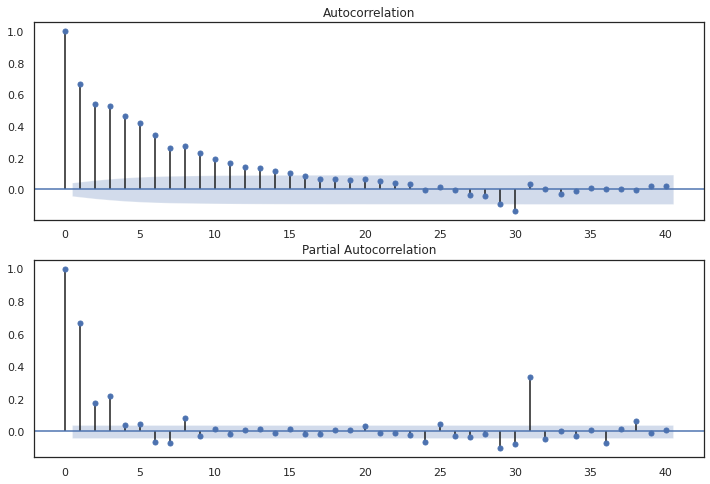

In [92]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[31:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[31:],lags=40,ax=ax2)

In [93]:
model_s=sm.tsa.statespace.SARIMAX(df['price'],order=(3, 1, 0),seasonal_order=(3,1,0,30))
results=model_s.fit()

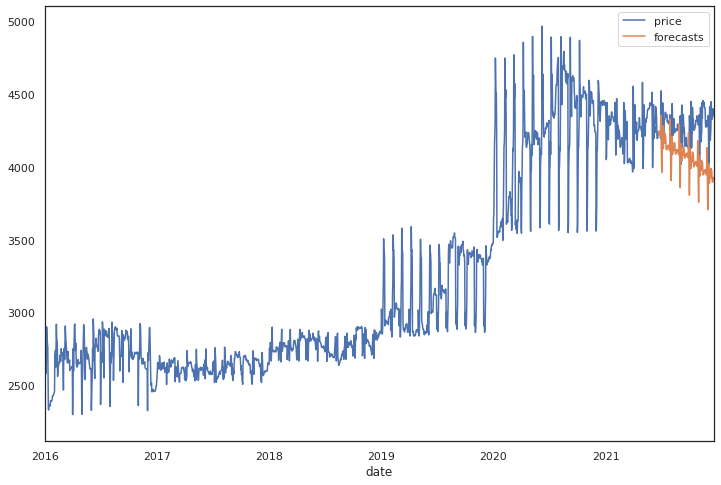

In [94]:
df['forecasts']=results.predict(start=2000,end=2182,dynamic=True)
df[['price','forecasts']].plot(figsize=(12,8))

In [95]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2182
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 30)   Log Likelihood              -13205.833
Date:                            Wed, 14 Dec 2022   AIC                          26425.665
Time:                                    17:18:07   BIC                          26465.381
Sample:                                01-01-2016   HQIC                         26440.194
                                     - 12-21-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3160      0.009    -34.172      0.000      -0.334      -0.298
ar.L2         -0.3018      0.015    -20.104      0.000      -0.331      -0.272
ar.L3         -0.0937      0.014     -6.589      0.000      -0.122      -0.066
ar.S.L30      -0.3884      0.010    -38.594      0.000      -0.408      -0.369
ar.S.L60      -0.2531      0.010    -26.629      0.000      -0.272      -0.234
ar.S.L90      -0.1570      0.012    -12.746      0.000      -0.181      -0.133
sigma2      1.255e+04    143.602     87.364      0.000    1.23e+04    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             26730.98
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               4.66   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
results.predict(start=1,end=2181)

2016-01-02    2248.298813
2016-01-03    2449.780613
2016-01-04    2707.177073
2016-01-05    2578.884906
2016-01-06    2598.257183
                 ...     
2021-12-17    4385.341438
2021-12-18    4364.084492
2021-12-19    4383.094444
2021-12-20    4387.684324
2021-12-21    4372.778018
Freq: D, Name: predicted_mean, Length: 2181, dtype: float64

In [97]:
import seaborn as sns

In [98]:
model_s1=sm.tsa.statespace.SARIMAX(df['price'],order=(0, 1, 3),seasonal_order=(0,1,3,30))
results=model_s1.fit()

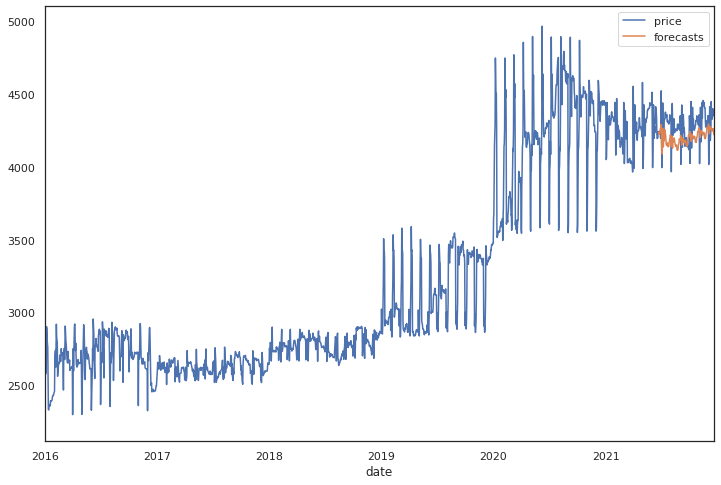

In [99]:
df['forecasts']=results.predict(start=2000,end=2182,dynamic=True)
df[['price','forecasts']].plot(figsize=(12,8))

In [100]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              price   No. Observations:                 2182
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 30)   Log Likelihood              -13102.985
Date:                            Wed, 14 Dec 2022   AIC                          26219.969
Time:                                    17:23:27   BIC                          26259.685
Sample:                                01-01-2016   HQIC                         26234.499
                                     - 12-21-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2632      0.011    -23.069      0.000      -0.286      -0.241
ma.L2         -0.1911      0.017    -11.090      0.000      -0.225      -0.157
ma.L3         -0.0226      0.017     -1.335      0.182      -0.056       0.011
ma.S.L30      -0.5806      0.535     -1.085      0.278      -1.629       0.468
ma.S.L60      -0.2382      0.225     -1.059      0.290      -0.679       0.203
ma.S.L90      -0.1808      0.100     -1.804      0.071      -0.377       0.016
sigma2      1.089e+04   5838.504      1.866      0.062    -551.157    2.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             45313.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
predict=results.predict(start=1,end=2181)

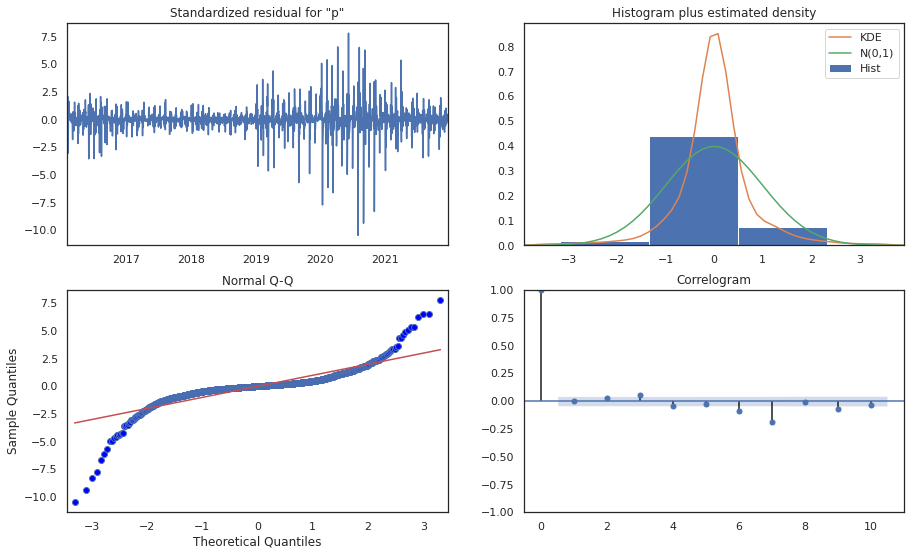

In [102]:
results.plot_diagnostics(figsize=(15,9))
plt.show()

In [103]:
mse = ((predict - df['price']) ** 2).mean()

In [104]:
import math
from math import sqrt

In [105]:
rmse=sqrt(mse)
rmse

108.94926165013888